# Manual
To run the script please create, in the same folder containing the notebook, a folder named 'data' containing the dataset that came with the challange, already unzipped.

# Preliminaries

## Set-Up environment

### Mount Google Drive

In [1]:
WORK_DIRECTORY = '/gdrive/MyDrive/AN2DL\ -\ Challenges/'

from google.colab import drive
drive.mount('/gdrive')
%cd $WORK_DIRECTORY

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/11eKW2WEwoP-WDr7xm8XSO8STbxqotVyP/AN2DL - Challenges


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn import preprocessing
import seaborn as sns
import pandas as pd

# Load Data

In [5]:
ORIGINAL_DATA_PATH = 'data/public_data.npz'
FILTERED_DATA_PATH = 'data/filtered_data.npz'

In [6]:
# Loading function
def load_data(file_path):
    npz_data = np.load(file_path, allow_pickle=True)

    data = npz_data['data']
    labels = npz_data['labels']

    # Load the dataset from the "data.npz" file with allow_pickle=True
    data = np.load(file_path, allow_pickle=True)

    # List the keys (array names) in the dataset
    print("Keys in the dataset:", list(data.keys()))

    # Access the images and labels from the dataset
    if 'data' in data and 'labels' in data:
        # check if stored data is normalized in [0, 1]
        if np.max(data['data']) < 1.1:
            images = data['data'] * 255  # Access the images array
        else:
            images = data['data']
        labels = data['labels']  # Access the labels array
    else:
        raise ValueError("\nThe dataset is missing 'data' or 'labels' arrays.")

    # Access and inspect the structure of the images and labels
    if 'data' in data:
        # Access the images array
        print("\nShape of images:", images.shape)  # Print the shape of the images
        print("Data type of images:", images.dtype)  # Print the data type of images

    if 'labels' in data:
        # Access the labels array
        print("\nShape of labels:", labels.shape)  # Print the shape of the labels
        print("Data type of labels:", labels.dtype)  # Print the data type of labels

    return images, labels

### Remove outliers

In [7]:
!pip install imagehash pillow

from PIL import Image
import imagehash

def remove_outliers(input_path=ORIGINAL_DATA_PATH, output_path=FILTERED_DATA_PATH):
    # Create a dictionary to store the image hashes and their corresponding indices
    hashes = {}
    duplicates = []

    # Define a threshold to consider two images as duplicates (adjust as needed)
    threshold = 5

    images, labels = load_data(input_path)

    # Calculate and compare image hashes
    for i, image in enumerate(images):
        # Convert the image data to a compatible format if necessary
        image = image.astype(np.uint8)  # Assuming it's a float32 image in [0, 1] range
        pil_image = Image.fromarray(image)
        image_hash = imagehash.average_hash(pil_image)

        # Check if the hash is already in the dictionary
        if image_hash in hashes:
            duplicates.append((i, hashes[image_hash]))
        else:
            hashes[image_hash] = i

    # Create a list of indices to remove
    indices_to_remove = [i for i, j in duplicates if j == 58 or j == 338] + [58, 338]

    # Remove the duplicate images and image 58/338 (i.e., Shrek and Trololo guy)
    filtered_images = np.delete(images, indices_to_remove, axis=0)
    filtered_labels = np.delete(labels, indices_to_remove, axis=0)

    # Assuming you have 'filtered_images' as your new dataset
    filtered_data = {'data': filtered_images, 'labels': filtered_labels}

    # Save the new dataset in an .npz archive
    np.savez(output_path, **filtered_data)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.5 MB/s eta 0:00:00


In [8]:
if not os.path.exists(FILTERED_DATA_PATH):
        remove_outliers(input_path=ORIGINAL_DATA_PATH, output_path=FILTERED_DATA_PATH)

data, labels = load_data(FILTERED_DATA_PATH)
input_shape = data.shape[1:] # Removing batch index

Keys in the dataset: ['data', 'labels']

Shape of images: (5004, 96, 96, 3)
Data type of images: float32

Shape of labels: (5004,)
Data type of labels: object


# Show Dataset's Pictures

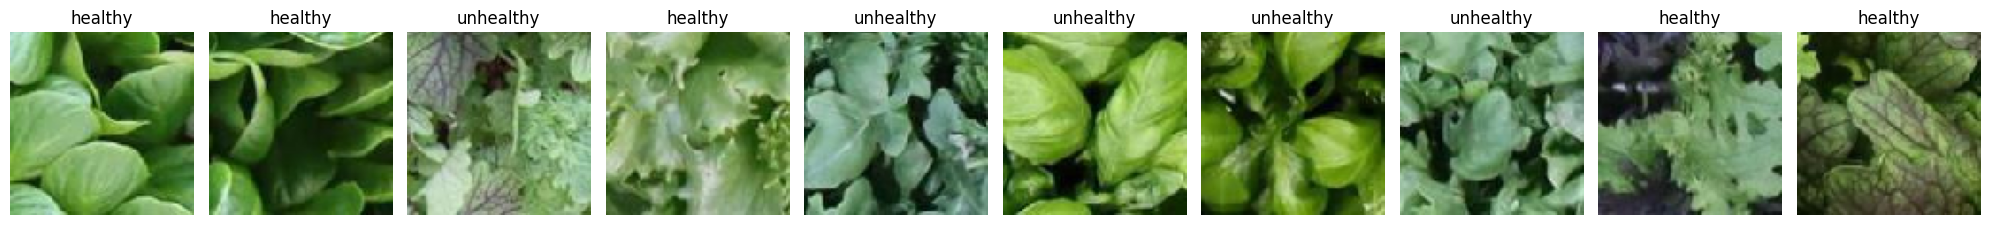

In [ ]:
def plot_imgs_from_dataset(D, num_img=20, img_per_line=5):

    # Create subplots for displaying items
    fig, axes = plt.subplots(num_img // img_per_line, img_per_line, figsize=(20, 9))
    axes = axes.flatten()
    for i in range(num_img):
        ax = axes[i]
        sample = np.random.randint(D.shape[0])
        img = D[sample]
        ax.imshow(img)
        ax.set_title(f'{labels[sample]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Number of images to display
num_img = 10
img_per_line = 10

plot_imgs_from_dataset(data, num_img, img_per_line)

# Preprocess Dataset

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [10]:
# split dataset into train, val, test sets
train_img, test_img, train_lbl, test_lbl = train_test_split(data, labels, test_size=0.3, random_state=seed, stratify=labels)
val_img, test_img, val_lbl, test_lbl = train_test_split(test_img, test_lbl, test_size=0.5, random_state=seed, stratify=test_lbl)

print('Training Data Shape:', train_img.shape)
print('Validation Data Shape:', val_img.shape)
print('Test Data Shape:', test_img.shape)
print('\nTraining Label Shape:', train_lbl.shape)
print('Validation Label Shape:', val_lbl.shape)
print('test Label Shape:', test_lbl.shape)

Training Data Shape: (3502, 96, 96, 3)
Validation Data Shape: (751, 96, 96, 3)
Test Data Shape: (751, 96, 96, 3)

Training Label Shape: (3502,)
Validation Label Shape: (751,)
test Label Shape: (751,)


In [11]:
# A script to balance the dataset by oversampling the unehalty elements

print("-- Old Percentages: --")
unique, counts = np.unique(train_lbl, return_counts=True)
for i in counts:
  print("Percentage: ", round(((i * 100)/len(train_lbl)), 2), "%")

sample_dim = counts[0]-counts[1]
unhealthy_ids = np.concatenate(np.where(train_lbl == 'unhealthy'), axis=0)

choices = np.random.choice(unhealthy_ids, sample_dim)

unhealthy_img_balanced = train_img[choices]
unhealthy_lbl_balanced = train_lbl[choices]

train_img = np.concatenate([unhealthy_img_balanced, train_img], axis=0)
train_lbl = np.concatenate([unhealthy_lbl_balanced, train_lbl], axis=0)

print("-- New Percentages: --")
unique, counts = np.unique(train_lbl, return_counts=True)
for i in counts:
  print("Percentage: ", round(((i * 100)/len(train_lbl)), 2), "%")


order = np.arange(len(train_lbl))
np.random.shuffle(order)
train_img = train_img[order]
train_lbl = train_lbl[order]

print(train_lbl.shape)

-- Old Percentages: --
Percentage:  61.96 %
Percentage:  38.04 %
-- New Percentages: --
Percentage:  50.0 %
Percentage:  50.0 %
(4340,)


In [12]:
# one-hot encoding labeling
label_encoder = LabelEncoder()
train_lbl = label_encoder.fit_transform(train_lbl)
val_lbl = label_encoder.fit_transform(val_lbl)

train_lbl = tfk.utils.to_categorical(train_lbl)
val_lbl = tfk.utils.to_categorical(val_lbl)

test_lbl = label_encoder.fit_transform(test_lbl)
test_lbl = tfk.utils.to_categorical(test_lbl)

# Image Augmentation Layer

In [13]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

# Normalize data to the range [0, 1]
# For EfficientNetB0 images should range from 0 to 255
# train_img = (train_img / 255).astype('float32')
# test_img = (test_img / 255).astype('float32')

# Build Model

### Training Parameters

In [14]:
# Training parameters

epochs = 50
batch_size = 64
patience = 5

### Callbacks

0.0005 1.093292561044877e-05


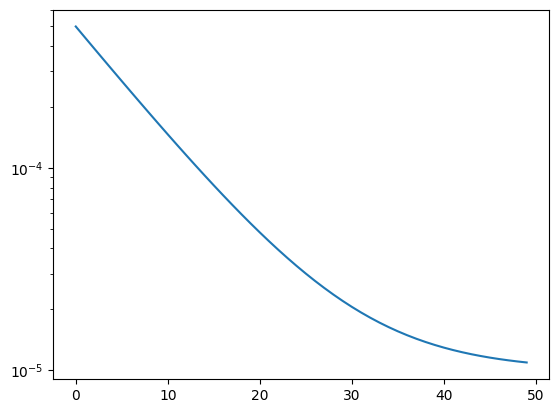

In [15]:
# A dynamic learning rate schedule. We used in some experimetn to find the best
# learning rate for a specific network. Also to slow the learning rate as the
# model converged to a maximum/minimu.

def dynamic_learning_rate(
    epoch=100,
    start_lr=0.0005,
    min_lr=0.00001,
    max_lr=0.0005,
    rampup_epochs=0,
    sustain_epochs=0,
    exp_decay = 0.88,
):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr

    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)

rng = [i for i in range(epochs)]
y = [dynamic_learning_rate(x) for x in rng]
plt.semilogy(rng, [dynamic_learning_rate(x) for x in rng])
print(y[0], y[-1])


In [16]:
CHECKPOINTS_PATH = 'checkpoints/b4'

# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    mode='min',
    restore_best_weights=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

# A callback to store the weights epoch per epoch as the training progresses
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='convnext',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# A callback to change the learning rate dynamically as specified
# by the function dynamic_learning_rate
lr_callback = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: dynamic_learning_rate(epoch),
    verbose=True
)




## Classical Networks exploration

### 1. LeNet

#### Create model

In [ ]:
def build_LeNet(input_shape,output_shape, seed=None):
    tf.random.set_seed(seed)

    preprocessing = tf.keras.Sequential([
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomFlip(mode="horizontal_and_vertical"),
        tfkl.RandomRotation(factor=np.pi, fill_mode='reflect', interpolation="bilinear")
    ], name='preprocessing')

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #preprocessing = preprocessing(input_layer)

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(5,5),
        padding='same',
        activation='relu',
        name='conv1'
    )(input_layer)

    # Pooling helps remove some redundancy in the data
    # Observe that pooling reduces the feature space
    pool1 = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='mp1'
    )(conv1)

    # A custom inception layer
    conv2_1 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3,3),
        padding='valid',
        activation='relu',
        name='conv2_1_1'
    )(pool1)

    conv2_2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(5,5),
        padding='valid',
        activation='relu',
        name='conv2_1_2'
    )(pool1)

    conv2_1plus = tfkl.Conv2D(
        filters=32,
        kernel_size=(3,3),
        padding='valid',
        activation='relu',
        name='conv2_2'
    )(conv2_1)

    # concatenate
    conv2 = tfkl.Concatenate()([conv2_1plus, conv2_2])

    pool2 = tfkl.MaxPooling2D(
        pool_size =(2,2),
        name='mp2'
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(5,5),
        padding='same',
        activation='relu',
        name='conv3'
    )(pool2)

    conv4 = tfkl.Conv2D(
        filters=64,
        kernel_size=(5,5),
        padding='same',
        activation='relu',
        name='conv4'
    )(conv3)

    conv4 = tfkl.Add()([conv3, conv4])

    pool3 = tfkl.MaxPooling2D(
        pool_size =(2,2),
        name='mp3'
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=128,
        kernel_size=(5,5),
        padding='same',
        activation='relu',
        name='conv5'
    )(pool3)

    pool4 = tfkl.MaxPooling2D(
        pool_size =(2,2),
        name='mp4'
    )(conv5)

    # sobstituing flattening layer with gap
    gap = tfkl.GlobalAveragePooling2D(name='gap')(pool4)

    classifier_layer=tfkl.Dense(
        units=256,
        activation='relu',
        name='dense1'
    )(gap)

    drop = tfkl.Dropout(rate=0.2)(classifier_layer)

    classifier_layer = tfkl.Dense(
        units=256,
        activation='relu',
        name='dense2'
    )(drop)

    drop = tfkl.Dropout(rate=0.2)(classifier_layer)

    classifier_layer=tfkl.Dense(
        units=128,
        activation='relu',
        name='dense3'
    )(drop)

    drop = tfkl.Dropout(rate=0.2)(classifier_layer)

    classifier_layer=tfkl.Dense(
        units=128,
        activation='relu',
        name='dense4'
    )(drop)

    drop = tfkl.Dropout(rate=0.2)(classifier_layer)

    output_layer = tfkl.Dense(
        units=output_shape,
        activation='softmax',
        name='Output'
    )(drop)

    # Connect input and output through the Model class
    model = tfk.Model(
        inputs=input_layer,
        outputs=output_layer,
        name='LeNet'
    )

    # Compile the model

    # AdamW adds the weight decay = regularization with L2 norm
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.Adam(),
        metrics=['loss'],
        run_eagerly=True
    )


    # Return the model
    return model

In [ ]:
# Build the LeNet model and display its summary
model = build_LeNet((96,96,3), 2)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

#### Train model

In [ ]:
epochs = 200
batch_size = 128

# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=train_img,
    y=train_lbl,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_img, val_lbl),
    callbacks=[early_stopping]
).history

# Save the trained model
model.save('Results/AlexNetFlatten')

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

#### Predictions

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(train_img, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
#micro, macro, weighted average - differente averages on the confusion matrix, and we will typically use the 'macro'

# Display the computed metrics

print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels_dic.values()), yticklabels=list(labels_dic.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### 2. AlexNet

#### Create model

In [ ]:
def build_model1(input_shape, output_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=96, kernel_size=11, padding='same', strides = 4, name='conv0')(preprocessing)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp1', pool_size=(3,3), strides = 2)(x)

    x = tfkl.Conv2D(filters=256, kernel_size=5, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp2', pool_size=(3,3), strides = 2)(x)

    x = tfkl.Conv2D(filters=384, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)

    x = tfkl.Conv2D(filters=384, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)
    x = tfkl.MaxPooling2D(name='mp3', pool_size=(3,3), strides = 2)(x)
    x = tfkl.Dropout(0.5)(x)

    # Flattening
    x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dense(units = 4096, name='dense1')(x)
    x = tfkl.ReLU(name='relu5')(x)
    x = tfkl.Dropout(0.5, name = 'drop1')(x)

    x = tfkl.Dense(units = 4096, name='dense2')(x)
    x = tfkl.ReLU(name='relu6')(x)

    output_layer = tfkl.Dense(units=output_shape, activation='softmax', name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='AlexNet')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
def build_model2(input_shape, output_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=96, kernel_size=7, padding='valid', strides = 2, name='conv0')(preprocessing)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp1', pool_size=(3,3), strides = 2)(x)

    x = tfkl.Conv2D(filters=256, kernel_size=5, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp2', pool_size=(3,3), strides = 2)(x)

    x = tfkl.Conv2D(filters=384, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)

    x = tfkl.Conv2D(filters=384, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)
    x = tfkl.MaxPooling2D(name='mp3', pool_size=(3,3), strides = 2)(x)
    x = tfkl.Dropout(0.5)(x)

    # GlobalAveragePooling instead of Flattening
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dense(units = 256, name='dense1')(x)
    x = tfkl.ReLU(name='relu5')(x)
    x = tfkl.Dropout(0.2, name = 'drop1')(x)

    x = tfkl.Dense(units = 256, name='dense2')(x)
    x = tfkl.ReLU(name='relu6')(x)
    x = tfkl.Dropout(0.2, name = 'drop2')(x)

    x = tfkl.Dense(units = 256, name='dense3')(x)
    x = tfkl.ReLU(name='relu7')(x)
    x = tfkl.Dropout(0.2, name = 'drop3')(x)

    x = tfkl.Dense(units = 256, name='dense4')(x)
    x = tfkl.ReLU(name='relu8')(x)

    output_layer = tfkl.Dense(units=output_shape, activation='softmax', name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='LeNet')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])
    # If instead of Adam we use Adaw, it has inside the weight decay parameter and we can use the l2 norm

    # Return the model
    return model

In [ ]:
model = build_model1(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

#### Train model

In [ ]:
epochs = 200
batch_size = 128

# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=train_img,
    y=train_lbl,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_img, val_lbl),
    callbacks=[early_stopping]
).history

# Save the trained model
model.save('Results/AlexNetFlatten')

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Delete the model instance to free up memory
del model

In [ ]:
# Load the saved LeNet model
model = tfk.models.load_model('Results/AlexNetFlatten')

In [ ]:
# Training set prediction
train_predictions = model.predict(train_img, verbose=0)
train_predictions = np.argmax(train_predictions,axis=-1)

train_gt = np.argmax(train_lbl,axis=-1)

train_accuracy = accuracy_score(train_gt, train_predictions)
print(f'Accuracy score over the train set: {round(train_accuracy,4)}')

In [ ]:
# Test set prediction
test_predictions = model.predict(test_img, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)

test_gt = np.argmax(test_lbl, axis=-1)

test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

#### Predictions

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(train_img, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
#micro, macro, weighted average - differente averages on the confusion matrix, and we will typically use the 'macro'

# Display the computed metrics

print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels_dic.values()), yticklabels=list(labels_dic.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Transfer Learning

In [17]:
from tensorflow.keras.applications import *

### 1. VGG16

In [ ]:
def build_VGG16(num_classes=2):

    inputs = layers.Input(shape=(96, 96, 3))

    # resize input imgs to fit EfficientNetB0 img size (224x224)
    res = tfkl.Resizing(224, 224, interpolation="bilinear", crop_to_aspect_ratio=False)

    x = img_augmentation(inputs)
    inp = res(x)

    #inp = tfk.applications.vgg16.preprocess_input(inp, data_format=None)
    model = VGG16(include_top=False, input_tensor=inp, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Dense(4069, activation = "relu", name = "dense1")(x)
    x = layers.Dense(4069, activation = "relu", name = "dense2")(x)
    x = layers.Dense(1000, activation = "relu", name = "dense3")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="VGG16")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

### 2. EfficientNetB0

In [ ]:
def build_EfficientNetB0(num_classes=2):

    inputs = layers.Input(shape=(96, 96, 3))

    # resize input imgs to fit EfficientNetB0 img size (224x224)
    res = tfkl.Resizing(224, 224, interpolation="bilinear", crop_to_aspect_ratio=False)

    x = img_augmentation(inputs)
    inp = res(x)

    model = EfficientNetB0(include_top=False, input_tensor=inp, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Dense(
        num_classes,
        kernel_regularizer=tfk.regularizers.L1L2(1e-3),
        name="pred")(x)
    outputs = layers.Activation('softmax', dtype='float32')(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

### 3. EfficientNetB4

In [ ]:
def build_EfficientNetB4(num_classes=2):

    inputs = layers.Input(shape=(96, 96, 3))

    # resize input imgs to fit EfficientNetB0 img size (224x224)
    res = tfkl.Resizing(380, 380, interpolation="bilinear", crop_to_aspect_ratio=False)

    x = img_augmentation(inputs)

    inp = res(x)

    base_model = EfficientNetB4(
        include_top=False,
        input_tensor=inp,
        weights="imagenet",
        pooling="avg"
    )

    # Freeze the pretrained weights
    base_model.trainable = False

    # Rebuild top

    x = layers.BatchNormalization()(base_model.output)
    x = layers.Activation('relu')(x)

    top_dropout_rate = 0.1

    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Dense(num_classes, name="pred", kernel_regularizer=tfk.regularizers.L2(1e-4))(x)
    outputs = layers.Activation("softmax", dtype="float32")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNetB4")

    # A learning rate >= 0.05 will give bad results
    optimizer = tf.keras.optimizers.AdamW(3e-4) #learning_rate=0.001, weight_decay=0.0004)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

### 3. EfficientNetB6

In [ ]:
def build_EfficientNetB6(num_classes=2):

    inputs = layers.Input(shape=(96, 96, 3))

    # resize input imgs to fit EfficientNetB6 img size (528x528)
    res = tfkl.Resizing(528, 528, interpolation="bilinear", crop_to_aspect_ratio=False)

    x = img_augmentation(inputs)
    inp = res(x)

    model = EfficientNetB6(include_top=False, input_tensor=inp, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

# Train Model

### Train in inference mode

In [ ]:
model = build_EfficientNetB4(2)

#tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

71686520/71686520 [==============================] - 4s 0us/step


In [ ]:
epochs = 50
batch_size = 64

# Train in inference mode
history = model.fit(
    x=train_img,
    y=train_lbl,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_img, val_lbl),
    callbacks=[early_stopping]
).history

Epoch 1/50
68/68 [==============================] - 42s 269ms/step - loss: 0.7354 - accuracy: 0.6023 - val_loss: 0.7060 - val_accuracy: 0.4660
Epoch 2/50
68/68 [==============================] - 15s 218ms/step - loss: 0.6008 - accuracy: 0.6924 - val_loss: 0.6334 - val_accuracy: 0.6565
Epoch 3/50
68/68 [==============================] - 15s 218ms/step - loss: 0.5632 - accuracy: 0.7233 - val_loss: 0.5878 - val_accuracy: 0.7111
Epoch 4/50
68/68 [==============================] - 15s 218ms/step - loss: 0.5205 - accuracy: 0.7429 - val_loss: 0.5393 - val_accuracy: 0.7710
Epoch 5/50
68/68 [==============================] - 15s 217ms/step - loss: 0.4945 - accuracy: 0.7652 - val_loss: 0.5140 - val_accuracy: 0.7723
Epoch 6/50
68/68 [==============================] - 15s 218ms/step - loss: 0.4964 - accuracy: 0.7673 - val_loss: 0.4633 - val_accuracy: 0.8096
Epoch 7/50
68/68 [==============================] - 15s 218ms/step - loss: 0.4766 - accuracy: 0.7825 - val_loss: 0.4503 - val_accuracy: 0.8123

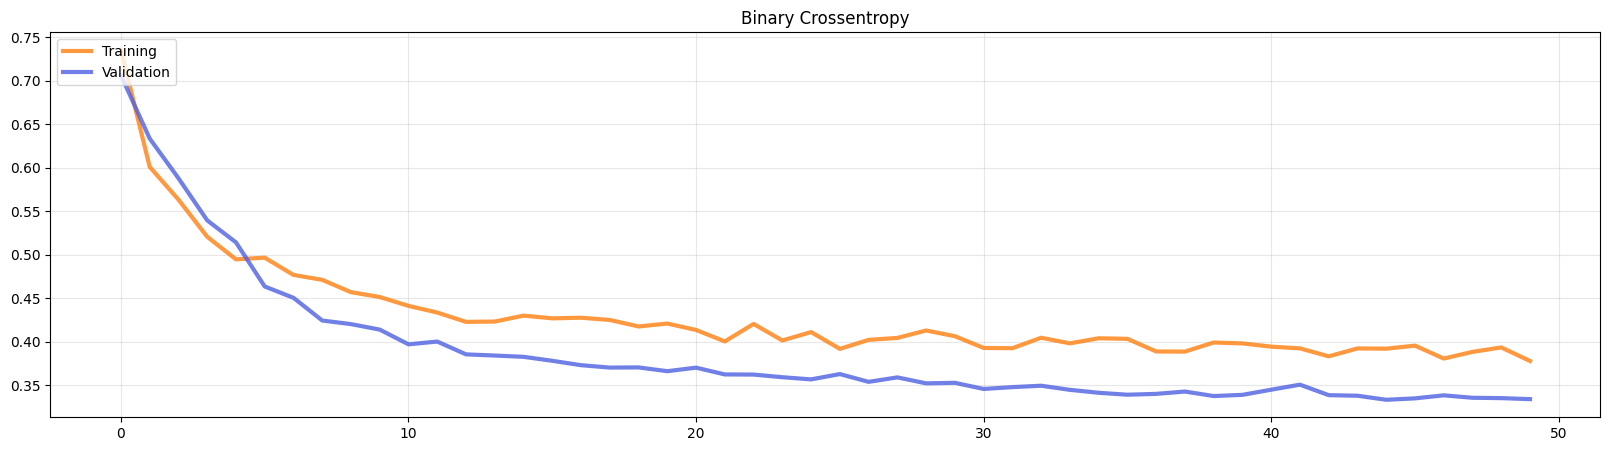

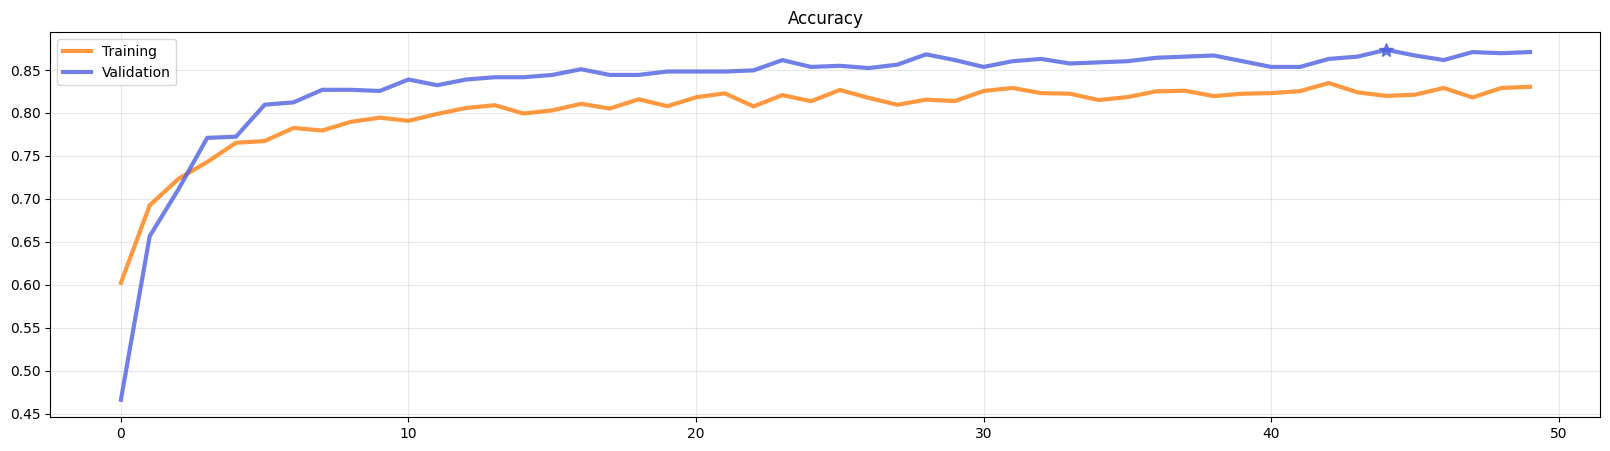

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
model.save('nets/EfficientNetB4-inference.keras')

In [18]:
model = tfk.models.load_model('nets/EfficientNetB4-inference.keras')

In [19]:
fine_tuning_lr = 4e-4
fine_tuning_wd = 4e-6

def unfreeze_model(model, slice=slice(-20, None), unfreeze=True):

    # We unfreeze the layers while leaving BatchNorm layers frozen
    for layer in model.layers[slice]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = unfreeze

    # we need to compile the model again after performing
    # modification to the network architecture
    model.compile(
        # lower the learning rate for this phase
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=fine_tuning_lr,
            weight_decay=fine_tuning_wd),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )



# the last element in the slice is excluded
block6_end = slice(327, None)
block7_end = slice(446, None)

# unfreeze model and train again
unfreeze_model(model, block7_end, unfreeze=True)

# Unfreezing inner dropout layers can help with generalization when
# unfreezing many layers (e.g. from block6)
# for layer in model.layers[-100:]:
#     if isinstance(layer, tfk.layers.Dropout):
#         layer.rate = 0.5

In [ ]:
# view the trainable layers
for i, layer in enumerate(model.layers):
     print(i, layer.name, layer.trainable)

0 input_2 True
1 img_augmentation True
2 resizing_1 False
3 rescaling False
4 normalization False
5 rescaling_1 False
6 stem_conv_pad False
7 stem_conv False
8 stem_bn False
9 stem_activation False
10 block1a_dwconv False
11 block1a_bn False
12 block1a_activation False
13 block1a_se_squeeze False
14 block1a_se_reshape False
15 block1a_se_reduce False
16 block1a_se_expand False
17 block1a_se_excite False
18 block1a_project_conv False
19 block1a_project_bn False
20 block1b_dwconv False
21 block1b_bn False
22 block1b_activation False
23 block1b_se_squeeze False
24 block1b_se_reshape False
25 block1b_se_reduce False
26 block1b_se_expand False
27 block1b_se_excite False
28 block1b_project_conv False
29 block1b_project_bn False
30 block1b_drop False
31 block1b_add False
32 block2a_expand_conv False
33 block2a_expand_bn False
34 block2a_expand_activation False
35 block2a_dwconv_pad False
36 block2a_dwconv False
37 block2a_bn False
38 block2a_activation False
39 block2a_se_squeeze False
40 blo

In [20]:
# Train the model agian with the unfrozen layers

epochs = 30
# lower the batch size for regularization
batch_size = 32

history = model.fit(
    x=train_img,
    y=train_lbl,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_img, val_lbl),
    callbacks=[early_stopping, model_checkpoint_callback]
).history

model.save('b4.keras')

Epoch 1/30
68/68 [==============================] - 109s 1s/step - loss: 0.4318 - accuracy: 0.8157 - val_loss: 0.5624 - val_accuracy: 0.8109
Epoch 2/30
68/68 [==============================] - 76s 1s/step - loss: 0.3464 - accuracy: 0.8505 - val_loss: 0.3900 - val_accuracy: 0.8575
Epoch 3/30
68/68 [==============================] - 76s 1s/step - loss: 0.2836 - accuracy: 0.8825 - val_loss: 0.4412 - val_accuracy: 0.8628
Epoch 4/30
68/68 [==============================] - 76s 1s/step - loss: 0.2574 - accuracy: 0.8959 - val_loss: 0.3120 - val_accuracy: 0.8921
Epoch 5/30
68/68 [==============================] - 76s 1s/step - loss: 0.2114 - accuracy: 0.9120 - val_loss: 0.2728 - val_accuracy: 0.8975
Epoch 6/30
68/68 [==============================] - 75s 1s/step - loss: 0.1985 - accuracy: 0.9171 - val_loss: 0.3629 - val_accuracy: 0.8815
Epoch 7/30
68/68 [==============================] - 75s 1s/step - loss: 0.1782 - accuracy: 0.9270 - val_loss: 0.4012 - val_accuracy: 0.8855
Epoch 8/30
68/68 [=

# Evaluate Performances

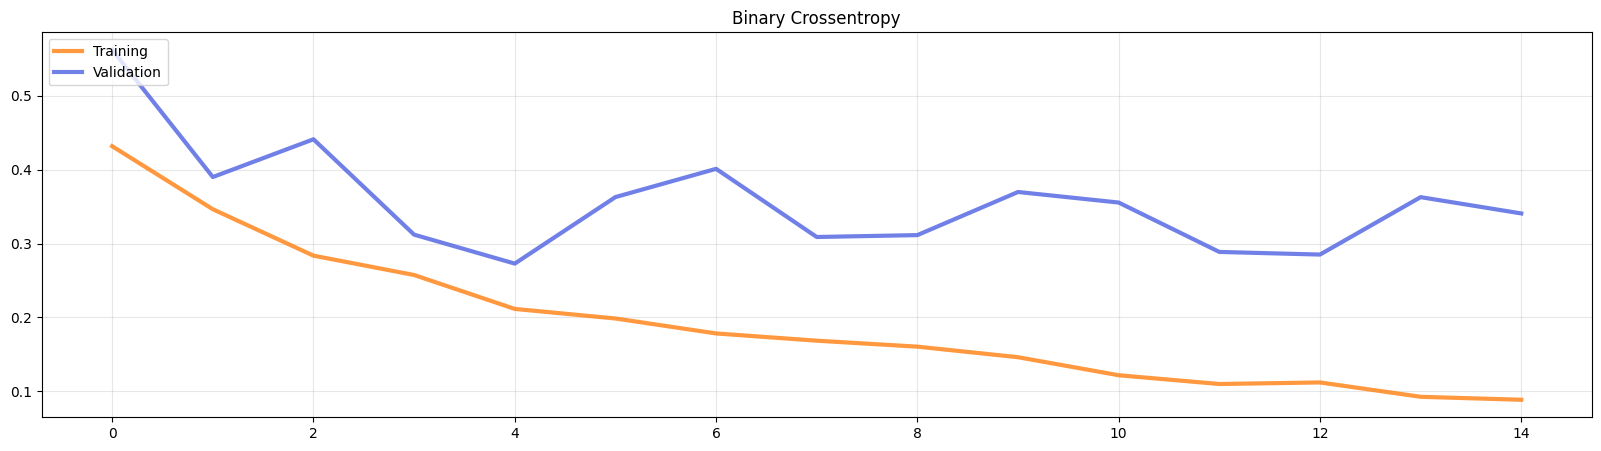

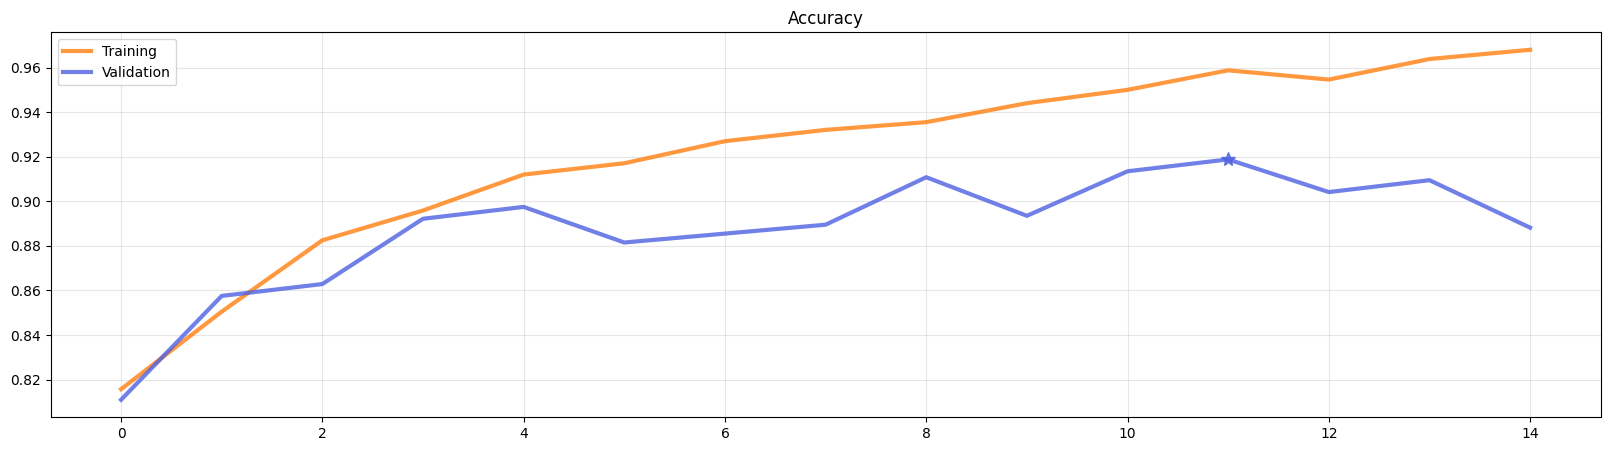

In [21]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
del model

# Make Inference

In [22]:
model = tfk.models.load_model('b4.keras')

In [23]:
# Predict labels for the entire test set
predictions = model.predict(test_img, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (751, 2)


Accuracy: 0.8828
Precision: 0.8844
Recall: 0.8647
F1: 0.8726


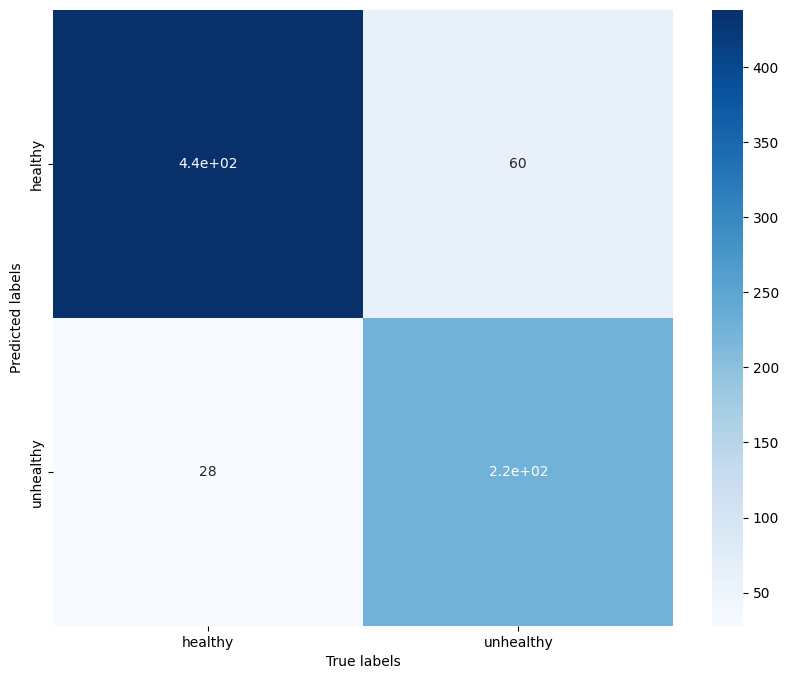

In [24]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Ensembles

We made the ensamble of two B4 networks trained on different fold of the dataset, moreover one was trained on a balanced dataset, the other with the unbalanced dataset. One of this networks tend to overfit alot, using an ensamble we can reduce thi phenomena and have a more balanced predictor.

In [44]:
model1  = tfk.models.load_model('nets/b4_1.keras')
model2  = tfk.models.load_model('nets/b4_2.keras')

In [55]:
# if the networks are build from the same function they can end having the same
# name and generate a conflict when combined in an ensamble
model1._name = 'EfficientNetB4-1'
model2._name = 'EfficientNetB4-2'

models = [model1, model2]

In [37]:
def ensembleModels(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models]                        # averaging outputs
    yAvg=tfkl.average(yModels)                                              # build model from same input and avg output
    modelEns = tfk.models.Model(inputs=model_input, outputs=yAvg, name='ensemble')

    return modelEns

In [56]:
model_input = tfkl.Input(shape=models[0].input_shape[1:]) # c*h*w
modelEns = ensembleModels(models, model_input)

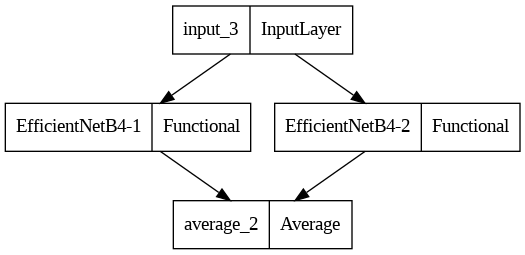

In [39]:
tfk.utils.plot_model(modelEns)

------------  Model 1 performance -----------
Accuracy: 0.8961
Precision: 0.9144
Recall: 0.8693
F1: 0.8842


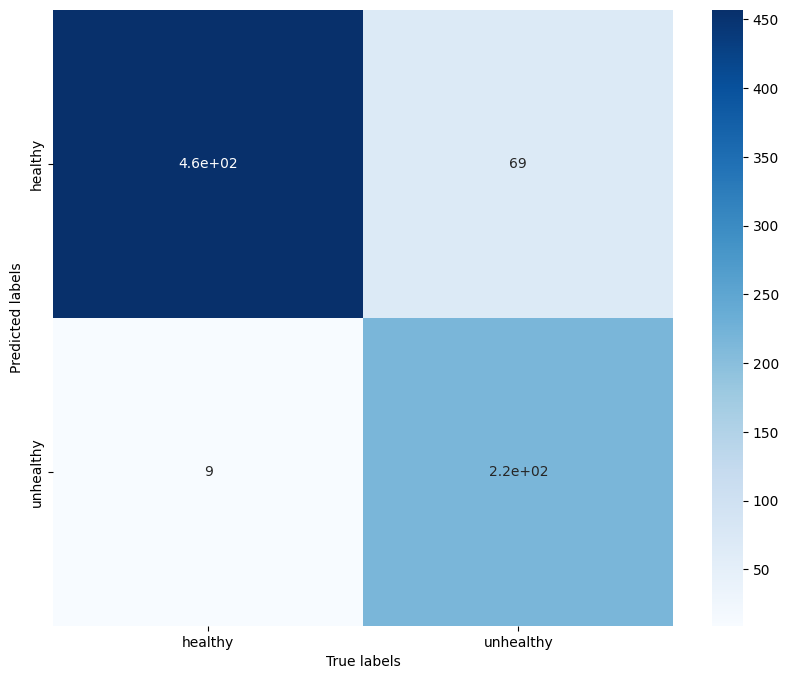




------------  Model 2 performance -----------
Accuracy: 0.9521
Precision: 0.9486
Recall: 0.9498
F1: 0.9492


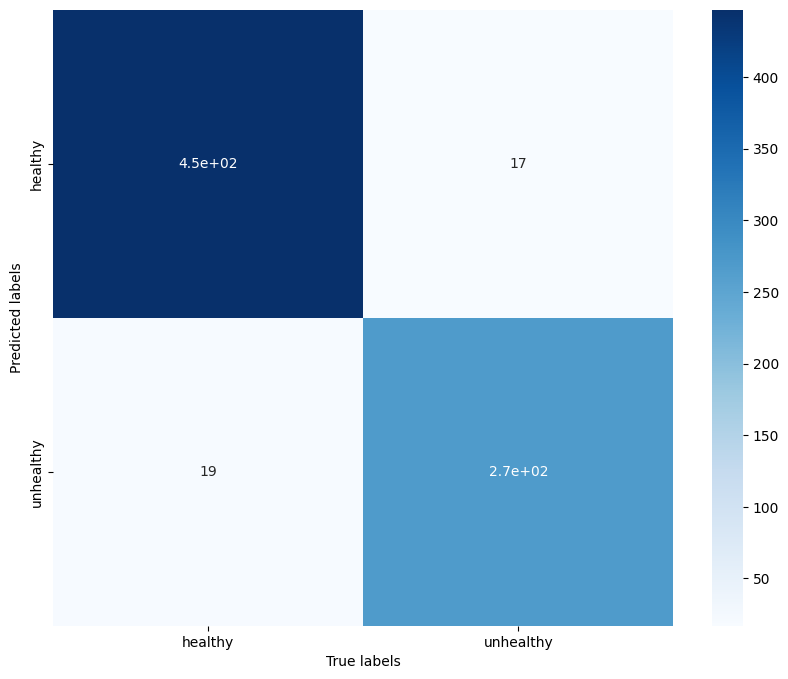




------------  Ensemble performance ------------
Accuracy: 0.9387
Precision: 0.9432
Recall: 0.9268
F1: 0.9338


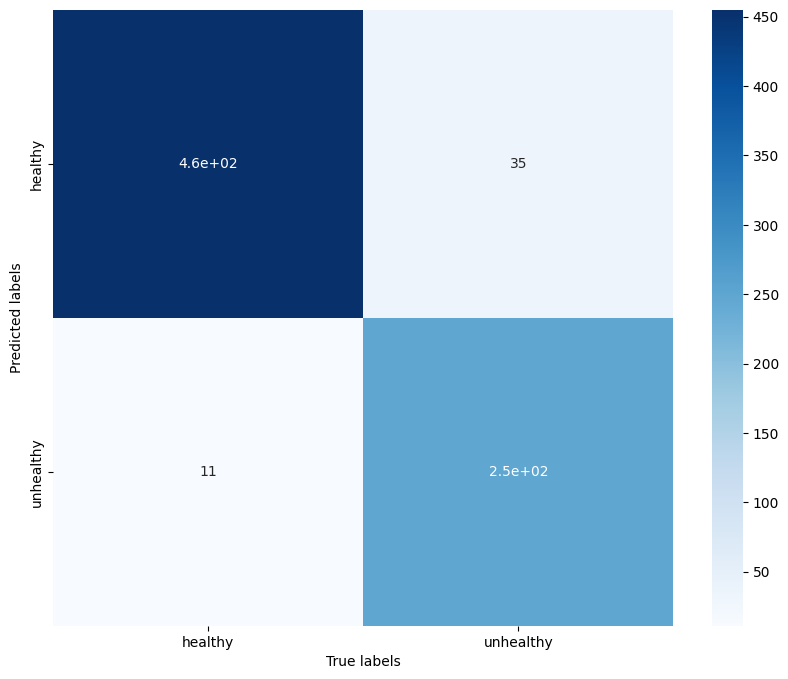

In [57]:
# Compute the confusion matrix
print('------------  Model 1 performance -----------')
predictions = model1.predict(test_img, verbose=0)
cm = confusion_matrix(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

print('\n\n')
print('------------  Model 2 performance -----------')
predictions = model2.predict(test_img, verbose=0)
cm = confusion_matrix(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

print('\n\n')
print('------------  Ensemble performance ------------')
predictions = modelEns.predict(test_img, verbose=0)
cm = confusion_matrix(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(test_lbl, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()